In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
from tensorflow import keras
import tensorflow as tf

In [2]:
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 6))
kernal=np.ones((4,4),np.uint8)

In [3]:
def structured_image(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
    light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
    light = cv2.threshold(light, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return light,blackhat

In [4]:
def detecting_edges(blackhat):
    gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,dx=1, dy=0, ksize=-1)
    gradX = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradX), np.max(gradX))
    gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
    gradX = gradX.astype("uint8")
    return gradX

In [5]:
def bitwise_operation(gradX):
    gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
    gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
    thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = cv2.bitwise_and(thresh, thresh, mask=light)
    thresh= cv2.morphologyEx(thresh, cv2.MORPH_OPEN,rectKern,iterations=2)
    thresh=cv2.dilate(thresh,rectKern,iterations=2)
    return thresh

In [6]:
def plate_detection(thresh,img):
    lpCnt = None
    roi = None 
    licensePlate=None
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    def value(z):
        x,y,w,h=cv2.boundingRect(z)
        return w*h
    contours, hier = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours=sorted(contours,key=value,reverse=True)
    for c in sorted_contours:
        (x, y, w, h) = cv2.boundingRect(c)
        ar = w / float(h)
        if ar >1 and ar <= 6:

            lpCnt = c
            licensePlate = gray[y:y + h, x:x + w]
            roi = cv2.threshold(licensePlate, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
            break
    return licensePlate,roi

In [7]:
def char_contours_detection(licensePlate,roi):
    data=[]
    def value(z):
        x,y,w,h=cv2.boundingRect(z)
        return w*h
    contours, hier = cv2.findContours(roi, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours=sorted(contours,key=value,reverse=True)
    licensePlate=cv2.cvtColor(licensePlate,cv2.COLOR_BGR2RGB)
    for x in sorted_contours:
        x,y,w,h=cv2.boundingRect(x)
        if(1<=h//w<=4 and h!=licensePlate.shape[0] and w!=licensePlate.shape[1] and h>=licensePlate.shape[0]//3 and w<licensePlate.shape[1]//2):
            cv2.rectangle(licensePlate,(x,y),(x+w,y+h),(0,255,0),1)
            data.append([x,y,w,h])
    return data
    

In [8]:
def image_prediction(data):
    def comp(x):
        return x[0]
    categories={0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}
    data=sorted(data,key=comp)
    model = keras.models.load_model("alpha_model2.h5")
    new_img=[]
    for x in data:
        img=cv2.resize(roi[x[1]:x[1]+x[3],x[0]:x[0]+x[2]],(34,34))
        img=cv2.copyMakeBorder(img.copy(),3,3,3,3,cv2.BORDER_CONSTANT,value=(0,0,0))
        new_img.append(img)
    for x in new_img:
        rect,x=cv2.threshold(x,125,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        x=cv2.resize(x,(40,40))
        x= cv2.morphologyEx(x, cv2.MORPH_CLOSE,None,iterations=1)
        new_img=x.reshape(-1,40,40,1)
        new_img=new_img/255
        value=categories[np.argmax(model.predict(new_img))]
        plt.imshow(x)
        print(value)
        plt.show()
    

input image path:/home/crowwar/Desktop/index1.png
H


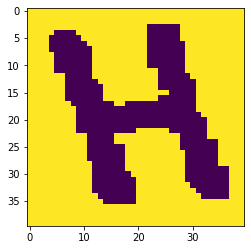

R


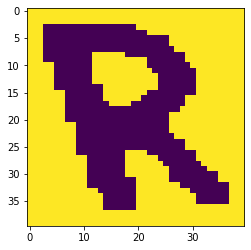

Z


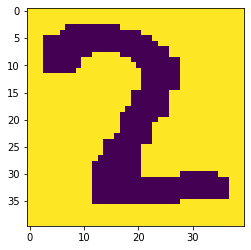

6


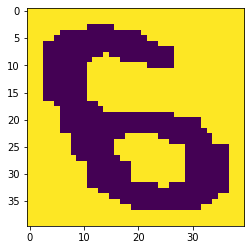

B


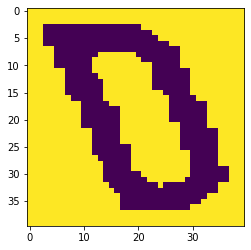

W


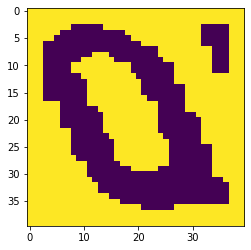

B


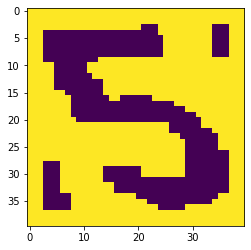

S


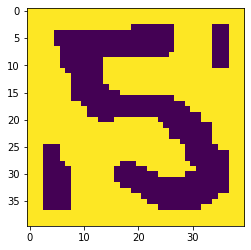

M


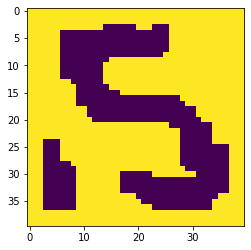

X


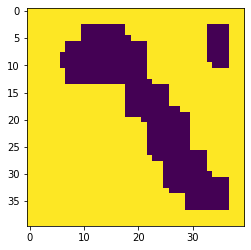

In [15]:
if __name__=="__main__":
    image_path=input("input image path:")
    img=cv2.imread(image_path)
    light,blackhat=structured_image(img)
    gradX=detecting_edges(blackhat)
    thresh=bitwise_operation(gradX)
    licensePlate,roi=plate_detection(thresh,img)
    data=char_contours_detection(licensePlate,roi)
    image_prediction(data)